In [6]:
import gymnasium
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

np.set_printoptions(precision=3, suppress=True)

def aggregation_features(state: np.array, centers: np.array) -> np.array:
    distance = ((state[:, None, :] - centers[None, :, :])**2).sum(-1)
    return (distance == distance.min(-1, keepdims=True)) * 1.0  # make it float

def expected_return(env, weights, gamma, episodes=100):
    G = np.zeros(episodes)
    for e in range(episodes):
        s, _ = env.reset(seed=e)
        done = False
        t = 0
        while not done:
            phi = get_phi(s)
            Q = np.dot(phi, weights).ravel()
            a = eps_greedy_action(Q, 0.0)
            s_next, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            G[e] += gamma**t * r
            s = s_next
            t += 1
    return G.mean()

def eps_greedy_action(Q, eps):
    if np.random.rand() < eps:
        return np.random.randint(n_actions)
    else:
        best = np.argwhere(Q == Q.max())
        i = np.random.choice(range(best.shape[0]))
        return best[i][0]

def fqi(seed):
    data = dict()
    data["s"] = []
    data["a"] = []
    data["r"] = []
    data["s_next"] = []
    data["done"] = []

    eps = 1.0
    idx_data = 0
    tot_steps = 0
    weights = np.zeros((phi_dummy.shape[1], n_actions))
    exp_return = expected_return(env_eval, weights, gamma, episodes_eval)
    abs_td_error = np.nan
    exp_return_history = np.zeros((max_steps))
    td_error_history = np.zeros((max_steps))
    pbar = tqdm(total=max_steps)
    while True:
        s, _ = env.reset(seed=seed+tot_steps)  # note that this does not make really unique seeds, but let's keep it simple
        done = False
        ep_steps = 0
        while not done and tot_steps < max_steps:
            
            phi = get_phi(s)
            Q = np.dot(phi, weights).ravel()  # Q is (n_actions,)
            a = eps_greedy_action(Q, eps=eps)

            s_next, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated

            # Store sample
            data["s"].append(s)
            data["a"].append(a)
            data["r"].append(r)
            data["s_next"].append(s_next)
            data["done"].append(done)
            idx_data += 1

            # After collecting enough data, perform FQI
            if idx_data % datasize == 0:
                s_array = np.array(data["s"])
                a_array = np.array(data["a"])
                r_array = np.array(data["r"])
                s_next_array = np.array(data["s_next"])
                done_array = np.array(data["done"])

                phi = get_phi(s_array)
                phi_next = get_phi(s_next_array)

                for _ in range(fitting_iterations):
                    # Compute TD target (fixed during gradient steps)
                    td_target = r_array + gamma * (1.0 - done_array) * np.dot(
                        phi_next, weights
                    ).max(axis=1)

                    for _ in range(gradient_steps):
                        # Compute TD prediction
                        td_prediction = np.dot(phi, weights)
                        weights_before_fit = weights.copy()

                        for act in range(n_actions):
                            idx = a_array == act
                            weights_before_step = weights.copy()
                            if np.sum(idx) == 0:
                                continue
                            td_error_act = td_target[idx] - td_prediction[idx, act]
                            gradient = td_error_act[:, None] * phi[idx]
                            gradient_mean = gradient.mean(axis=0)
                            weights[:, act] += alpha * gradient_mean
                            if np.allclose(weights, weights_before_step, rtol=1e-5, atol=1e-5):
                                break
                        if np.allclose(weights, weights_before_fit, rtol=1e-5, atol=1e-5):
                            break

                # After the updates, compute td_error for logging
                td_prediction = np.dot(phi, weights)
                abs_td_error = np.abs(td_target - td_prediction[np.arange(len(a_array)), a_array]).mean()

            if tot_steps % log_frequency == 0:
                exp_return = expected_return(env_eval, weights, gamma, episodes_eval)
                pbar.set_description(
                    f"TDE: {abs_td_error:.3f}, " +
                    f"G: {exp_return:.3f}"
                )
            exp_return_history[tot_steps] = exp_return
            td_error_history[tot_steps] = abs_td_error

            s = s_next
            tot_steps += 1
            ep_steps += 1
            eps = max(eps - 1.0 / max_steps, 0.5)

        pbar.update(ep_steps)
        if tot_steps >= max_steps:
            break

    pbar.close()
    return td_error_history, exp_return_history


env_id = "Gym-Gridworlds/Empty-2x2-v0"
env = gymnasium.make(env_id, coordinate_observation=True, random_action_prob=0.1, reward_noise_std=0.01)
env_eval = gymnasium.make(env_id, coordinate_observation=True, max_episode_steps=10)  # 10 steps only for faster eval
episodes_eval = 10  # max expected return will be 0.994

state_dim = env.observation_space.shape[0]
n_actions = env.action_space.n

# automatically set centers and sigmas
n_centers = [2, 2]
centers = np.array(
    np.meshgrid(*[
        np.linspace(env.observation_space.low[i], env.observation_space.high[i], n_centers[i])
        for i in range(env.observation_space.shape[0])
    ])
).reshape(env.observation_space.shape[0], -1).T
sigmas = (env.observation_space.high - env.observation_space.low) / n_centers / 4.0 + 1e-8 # 4.0 is arbitrary
get_phi = lambda state : aggregation_features(state.reshape(-1, state_dim), centers)  # reshape because feature functions expect shape (N, S)
phi_dummy = get_phi(env.reset()[0])  # to get the number of features

# hyperparameters
gradient_steps_sweep = [1, 100, 1000]  # N in pseudocode
fitting_iterations_sweep = [1, 100, 1000]  # K in pseudocode
datasize_sweep = [1, 100, 1000]  # D in pseudocode
gamma = 0.99
alpha = 0.05
max_steps = 10000
log_frequency = 100
n_seeds = 10

results_ret = np.zeros((
    len(gradient_steps_sweep),
    len(fitting_iterations_sweep),
    len(datasize_sweep),
    n_seeds,
    max_steps,
))
results_tde = np.zeros_like(results_ret)

for i, gradient_steps in enumerate(gradient_steps_sweep):
    for j, fitting_iterations in enumerate(fitting_iterations_sweep):
        for k, datasize in enumerate(datasize_sweep):
            label = f"Grad Steps: {gradient_steps}, " + \
                    f"Fit Iters: {fitting_iterations}, " + \
                    f"Datasize: {datasize}"
            print(label)
            for seed in range(n_seeds):
                td_error, exp_return = fqi(seed)
                results_tde[i, j, k, seed] = td_error
                results_ret[i, j, k, seed] = exp_return

Grad Steps: 1, Fit Iters: 1, Datasize: 1


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

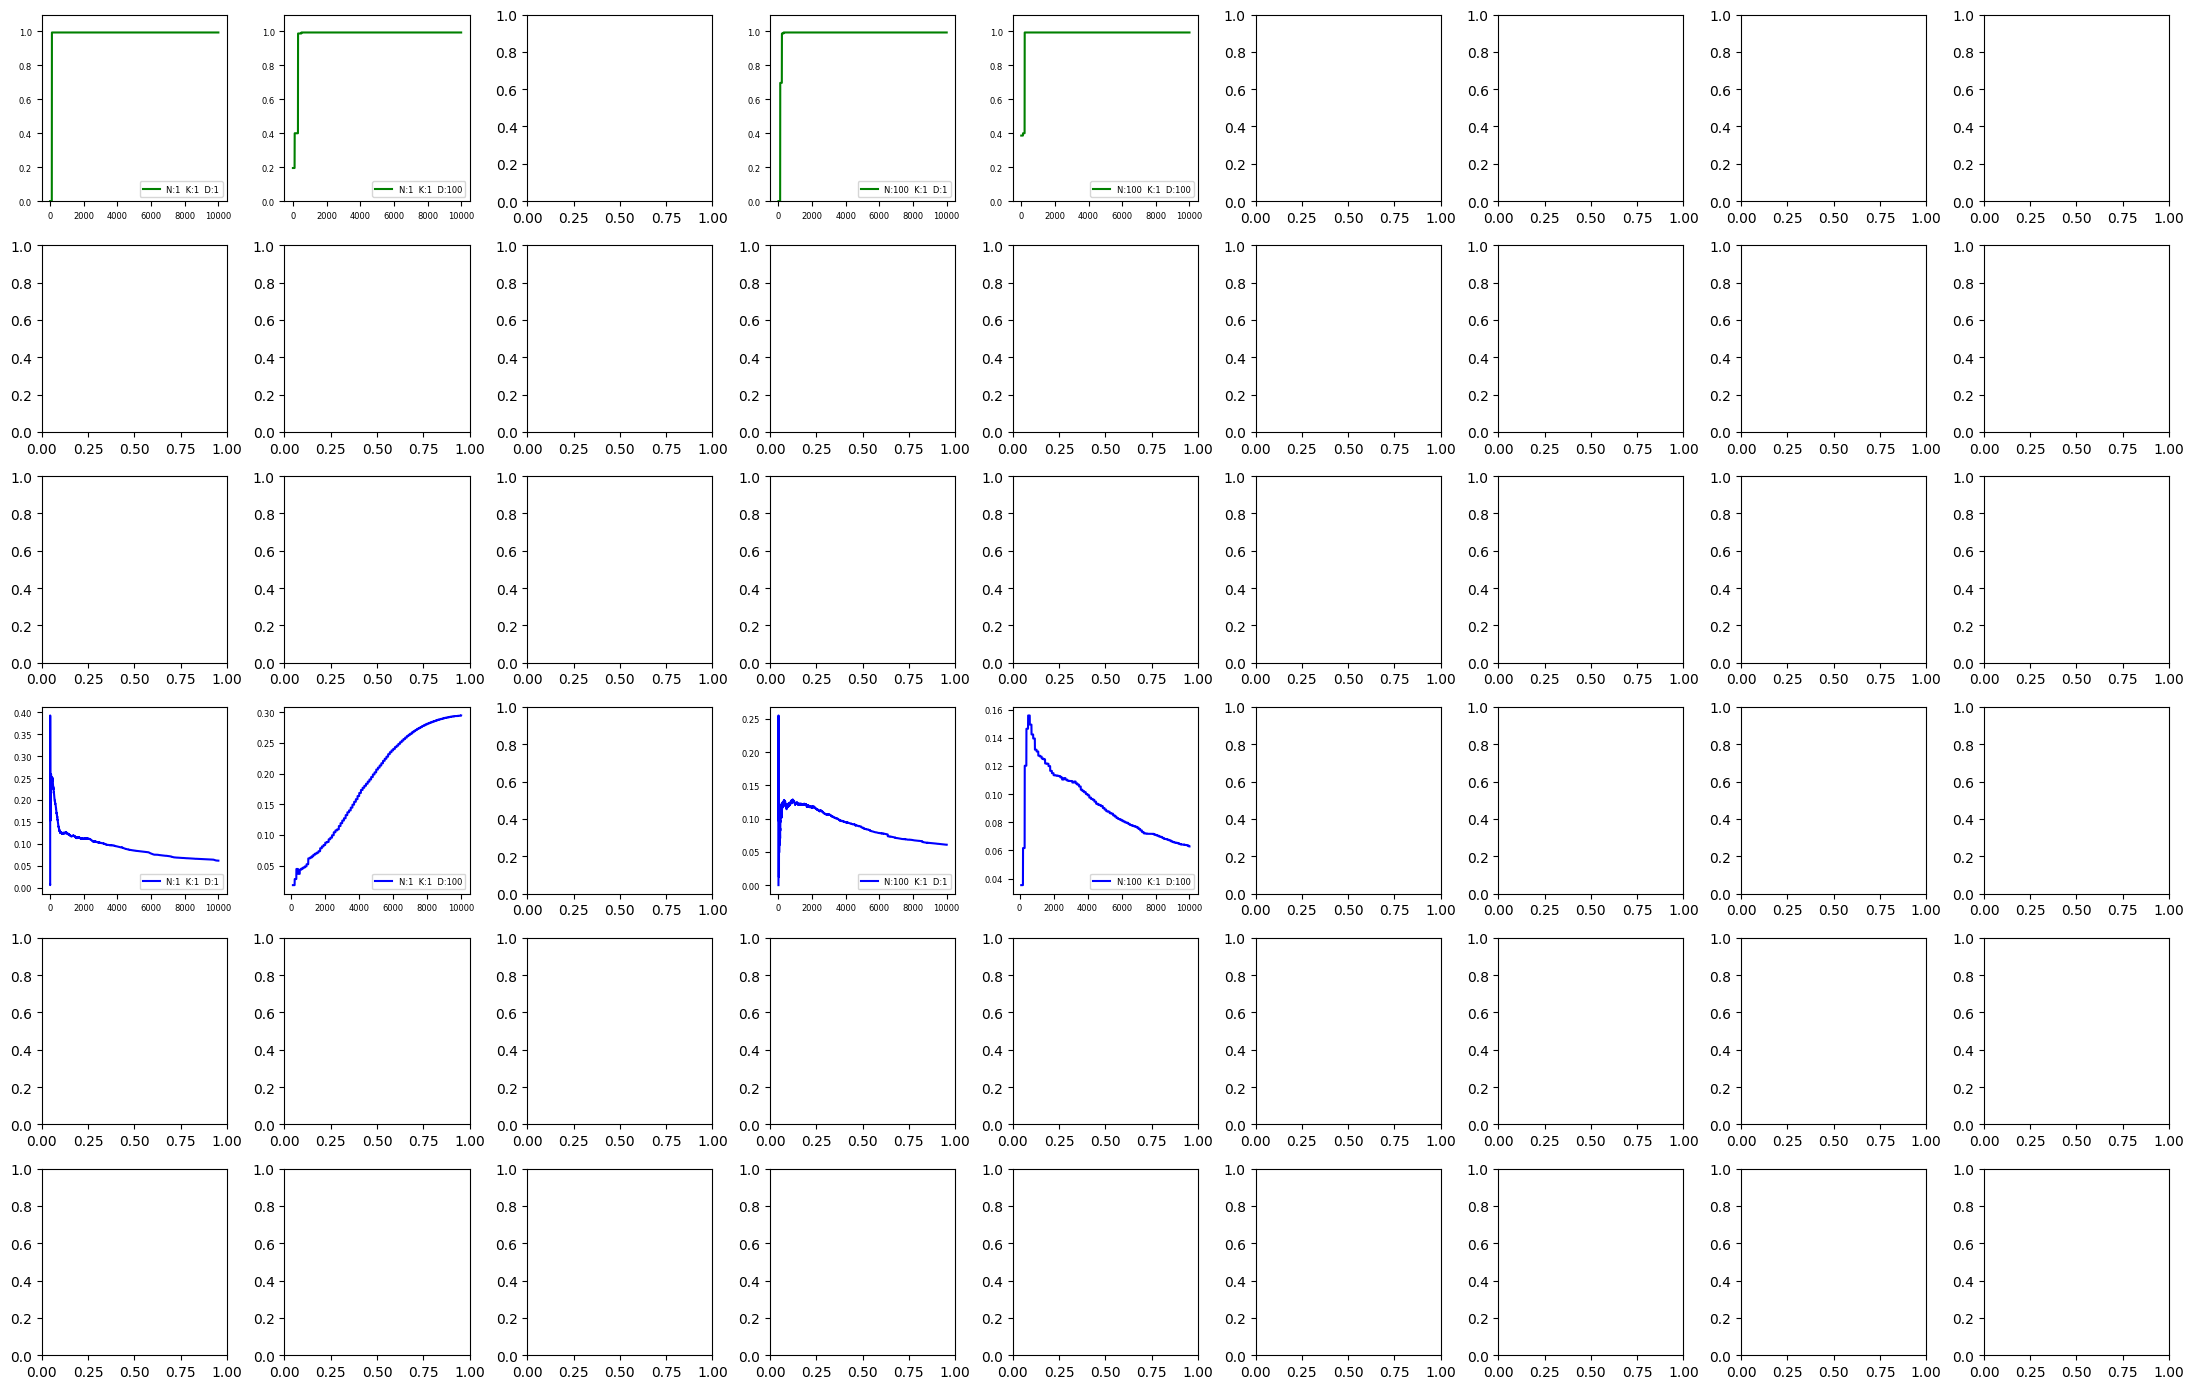

In [11]:
fig, axs = plt.subplots(3*2, 3*3, figsize=(22,14))
for i, N in enumerate(gradient_steps_sweep):
    for j, K in enumerate(fitting_iterations_sweep):
        for k, D in enumerate(datasize_sweep):
            axs[j][k+i*3].plot(results_ret[i, j, k].mean(0), label=f"N:{N}  K:{K}  D:{D}", color="g")
            axs[j][k+i*3].legend(prop={'size': 6}, loc="lower right")
            axs[j][k+i*3].set_ylim([0.0, 1.1])
            axs[j][k+i*3].tick_params(labelsize=6)
            axs[j+3][k+i*3].plot(results_tde[i, j, k].mean(0), label=f"N:{N}  K:{K}  D:{D}", color="b")
            axs[j+3][k+i*3].legend(prop={'size': 6}, loc="lower right")
            axs[j+3][k+i*3].tick_params(labelsize=6)
            if i == 0 and j == 1 and k == 0:
                axs[j][k+i*3].set_ylabel("Return")
                axs[j+3][k+i*3].set_ylabel("TD Error")
            if j == 2:
                axs[j+3][k+i*3].set_xlabel("Steps")

fig.tight_layout()
plt.show()